In [1]:
import gymnasium as gym
import numpy as np
import time
from q_learning import QL
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pclib.nn.models import StochasticHebbian

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make('FrozenLake-v1', is_slippery=False)
ql = QL(env, 0.001, 0.9, epsilon=0.1)
ql.train(10000)
state_value = torch.tensor(ql.Q.max(1)).to(device)
print(state_value.reshape(4,4))

tensor([[ 3.7533e-01,  5.8422e-04,  5.3725e-02, -3.0594e-03],
        [ 4.5613e-01,  0.0000e+00,  2.7289e-01,  0.0000e+00],
        [ 5.3617e-01,  6.1645e-01,  7.0002e-01,  0.0000e+00],
        [ 0.0000e+00,  2.1108e-01,  7.8989e-01,  0.0000e+00]], device='cuda:0',
       dtype=torch.float64)


In [20]:
seed = 42
torch.manual_seed(seed)

model = StochasticHebbian(
    in_features=16,
    out_features=4,
    hidden_features=[],
    bias=False,
    actv_fn=F.tanh,
    noise_coeff=0.8,
    steps=1,
).to(device)
model.layers[0].weight.data = torch.zeros_like(model.layers[0].weight.data)

def format_obs(obs):
    obs = F.one_hot(torch.tensor(obs), num_classes=16).float().to(device)
    # baseline = torch.ones_like(obs).to(device) * 0.034
    # obs = baseline + (obs * 0.94)
    return obs

optimiser = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.2)

In [5]:
s = env.observation_space.sample()
# s = 11
print(f"state: {s}")
obs = format_obs(s).unsqueeze(0)
model.noise_coeff = 1.0
out, state = model(obs)
out, out.argmax(1)

state: 3


(tensor([[0.0928, 0.6640, 0.0644, 0.1788]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor([1], device='cuda:0'))

In [6]:
model.layers[-1].weight.data, model.layers[-1].bias

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
        device='cuda:0'),
 None)

In [7]:
model.layers[-1].weight.data, model.layers[-1].bias

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
        device='cuda:0'),
 None)

In [16]:
num_envs = 64
# envs = gym.vector.make('FrozenLake-v1', num_envs=num_envs, asynchronous=False, is_slippery=False)
envs = gym.make_vec('FrozenLake-v1', num_envs=num_envs, is_slippery=False)
obs = format_obs(envs.observation_space.sample())
model(obs)[0].shape

torch.Size([64, 4])

In [21]:
num_epochs = 500
final_rewards = []
delta_Ers = []
loop = tqdm(range(num_epochs), leave=False, total=num_epochs)
for epoch in loop:
    model.noise_coeff = 1.0 - (epoch / 750)

    if epoch > 0:
        loop.set_description(f"Epoch {epoch}/{num_epochs}, Reward: {final_rewards[-1]:.3f}, delta_Er: {delta_Ers[-1]:.3g}")
    state = envs.reset()[0]
    total_reward = [0] * num_envs
    done = np.array([False] * num_envs)
    prev_value = state_value[state]
    prev_state = state
    step = 0
    epoch_deltaErs = []
    while not done.all():
        step += 1
        if step % 300 == 0:
            print(f"{terminated + truncated}, {(terminated + truncated).all()}")
        obs = format_obs(state)
        with torch.no_grad():
            actions, s = model(obs)
            action = actions.argmax(dim=1).cpu().numpy()
        # print(s[-1], actions, action)

        state, reward, terminated, truncated, _ = envs.step(action)
        for i, t in enumerate(terminated):
            if t:
                total_reward[i] -= 0.2
        
        value = state_value[state] 
        total_reward += reward - 0.01
        done = done + terminated + truncated

        # reward has to be added in this env, because state set to 0 when goal is reached.
        # reward simulates state_value[final_state] as it is 1 when goal and 0 elsewhere.
        # this implementation will likely be different for other envs.
        same_state = prev_state == state
        delta_Er = (value - prev_value).float() - (0.5 * torch.tensor(same_state).to(device).float()) + torch.tensor(reward).float().to(device)
        epoch_deltaErs.append(delta_Er.mean().item())
        optimiser.zero_grad()
        model.update_parameters(s, delta_Er)
        optimiser.step()

        prev_value = value
        prev_state = state
    final_rewards.append(sum(total_reward) / len(total_reward))
    delta_Ers.append(sum(epoch_deltaErs) / len(epoch_deltaErs))



In [72]:
model.layers[-1].weight.data[:,14]

tensor([-3.4422, -3.3547,  3.4564, -3.3930], device='cuda:0')

Text(0.5, 1.0, 'Delta Er')

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\gymnasium\experimental\vector\async_vector_env.py:510: UserWarning: WARN: Calling `close` while waiting for a pending call to `step` to complete.
  logger.warn(


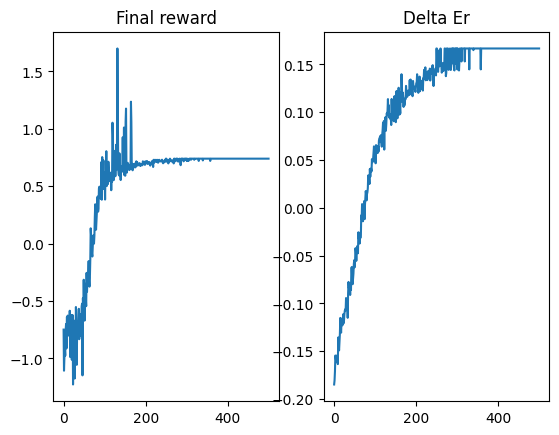

In [22]:
plt.subplot(1, 2, 1)
plt.plot(final_rewards)
plt.title("Final reward")
plt.subplot(1, 2, 2)
plt.plot(delta_Ers)
plt.title("Delta Er")

In [23]:
# Watch the agent play
model.noise_coeff = 0.0
env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='human')
QL.env = env
total_rewards = []
for i in range(3):
    total_reward = 0.0
    state = env.reset()[0]
    terminated, truncated = False, False
    while not terminated and not truncated:
        obs = format_obs(state).unsqueeze(0)
        actions, s = model(obs)
        action = actions.argmax(dim=1).cpu().numpy()
        state, reward, terminated, truncated, _ =env.step(action[0])
        total_reward += reward
        env.render()
        time.sleep(0.2)
    total_rewards.append(reward)

print(f"mean reward: {np.array(total_rewards).mean()}")
env.close()

mean reward: 1.0
